In [135]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LassoCV, Lasso

In [87]:
df = pd.read_csv("Datasets/clean_data_after_eda.csv")
df["date_activ"] = pd.to_datetime(df["date_activ"], format = '%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format = '%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format = '%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format = '%Y-%m-%d')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000131,4.100838e-05,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000003,1.217891e-03,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000004,9.450150e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000003,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.000011,2.896760e-06,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14606 non-null  object        
 1   channel_sales                   14606 non-null  object        
 2   cons_12m                        14606 non-null  int64         
 3   cons_gas_12m                    14606 non-null  int64         
 4   cons_last_month                 14606 non-null  int64         
 5   date_activ                      14606 non-null  datetime64[ns]
 6   date_end                        14606 non-null  datetime64[ns]
 7   date_modif_prod                 14606 non-null  datetime64[ns]
 8   date_renewal                    14606 non-null  datetime64[ns]
 9   forecast_cons_12m               14606 non-null  float64       
 10  forecast_cons_year              14606 non-null  int64         
 11  fo

In [89]:
df.nunique()

id                                14606
channel_sales                         8
cons_12m                          11065
cons_gas_12m                       2112
cons_last_month                    4751
date_activ                         1796
date_end                            368
date_modif_prod                    2129
date_renewal                        386
forecast_cons_12m                 13993
forecast_cons_year                 4218
forecast_discount_energy             12
forecast_meter_rent_12m            3528
forecast_price_energy_off_peak      516
forecast_price_energy_peak          329
forecast_price_pow_off_peak          41
has_gas                               2
imp_cons                           7752
margin_gross_pow_ele               2391
margin_net_pow_ele                 2391
nb_prod_act                          10
net_margin                        11965
num_years_antig                      13
origin_up                             6
pow_max                             698


In [153]:
price_df = pd.read_csv("Datasets/price_data.csv")
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [154]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


## Preparing Data for Feature Selection

In [90]:
pref_df = df.drop(columns=["id"])

In [91]:
column_names = pref_df.loc[:, pref_df.dtypes == object].columns
le = LabelEncoder()
for i in column_names:
    temp = le.fit_transform(pref_df[i])
    pref_df.drop(i, axis = 1, inplace = True )
    pref_df[i] = temp

In [92]:
pref_df.iloc[:, -3:].head()

,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,...,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,channel_sales,has_gas,origin_up
0,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,...,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1,4,1,4
1,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,...,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0,0,0,2
2,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,...,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0,4,0,2
3,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,...,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0,5,0,2
4,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,0.0,...,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14601,32270,47940,0,2012-05-24,2016-05-08,2015-05-08,2014-05-26,4648.01,0,0.0,...,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0,4,1,4
14602,7223,0,181,2012-08-27,2016-08-27,2012-08-27,2015-08-28,631.69,181,0.0,...,0.014939,0.005682,0.000299,0.014948,5.684001e-03,2.987132e-04,1,4,0,4
14603,1844,0,179,2012-02-08,2016-02-07,2012-02-08,2015-02-09,190.39,179,0.0,...,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,1,4,0,4
14604,131,0,0,2012-08-30,2016-08-30,2012-08-30,2015-08-31,19.34,0,0.0,...,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0,4,0,4


In [93]:
pref_df["year_activ"] = pref_df["date_activ"].dt.year
pref_df["month_activ"] = pref_df["date_activ"].dt.month
pref_df["day_activ"] = pref_df["date_activ"].dt.day

In [94]:
pref_df["year_end"] = pref_df["date_end"].dt.year
pref_df["month_end"] = pref_df["date_end"].dt.month
pref_df["day_end"] = pref_df["date_end"].dt.day

In [95]:
pref_df["year_modif_prod"] = pref_df["date_modif_prod"].dt.year
pref_df["month_modif_prod"] = pref_df["date_modif_prod"].dt.month
pref_df["day_modif_prod"] = pref_df["date_modif_prod"].dt.day  

In [96]:
pref_df["year_renewal"] = pref_df["date_renewal"].dt.year
pref_df["month_renewal"] = pref_df["date_renewal"].dt.month
pref_df["day_renewal"] = pref_df["date_renewal"].dt.day

In [110]:
pref_df = pref_df.drop(columns=["date_activ", "date_end", "date_modif_prod", "date_renewal"])

In [98]:
pref_df.iloc[:, -12:].head()

,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,...,day_activ,year_end,month_end,day_end,year_modif_prod,month_modif_prod,day_modif_prod,year_renewal,month_renewal,day_renewal
0,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,...,15,2016,6,15,2015,11,1,2015,6,23
1,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,...,21,2016,8,30,2009,8,21,2015,8,31
2,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,...,16,2016,4,16,2010,4,16,2015,4,17
3,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,...,30,2016,3,30,2010,3,30,2015,3,31
4,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,0.0,...,13,2016,3,7,2010,1,13,2015,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14601,32270,47940,0,2012-05-24,2016-05-08,2015-05-08,2014-05-26,4648.01,0,0.0,...,24,2016,5,8,2015,5,8,2014,5,26
14602,7223,0,181,2012-08-27,2016-08-27,2012-08-27,2015-08-28,631.69,181,0.0,...,27,2016,8,27,2012,8,27,2015,8,28
14603,1844,0,179,2012-02-08,2016-02-07,2012-02-08,2015-02-09,190.39,179,0.0,...,8,2016,2,7,2012,2,8,2015,2,9
14604,131,0,0,2012-08-30,2016-08-30,2012-08-30,2015-08-31,19.34,0,0.0,...,30,2016,8,30,2012,8,30,2015,8,31


In [100]:
churn_pop = pref_df.pop("churn")
pref_df.insert(len(pref_df.columns), "churn", churn_pop)

### Filter

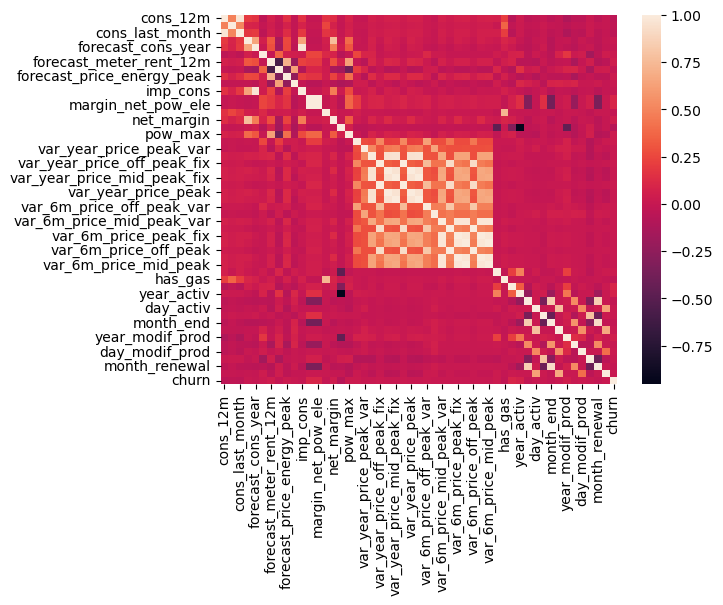

In [111]:
cor = pref_df.corr()
sns.heatmap(cor)
plt.show()

In [126]:
churn_cor = abs(cor["churn"])
churn_cor

cons_12m                          0.045968
cons_gas_12m                      0.037957
cons_last_month                   0.045284
forecast_cons_12m                 0.012949
forecast_cons_year                0.002558
forecast_discount_energy          0.017026
forecast_meter_rent_12m           0.044245
forecast_price_energy_off_peak    0.010837
forecast_price_energy_peak        0.029315
forecast_price_pow_off_peak       0.014778
imp_cons                          0.001583
margin_gross_pow_ele              0.095725
margin_net_pow_ele                0.095772
nb_prod_act                       0.014930
net_margin                        0.041135
num_years_antig                   0.074140
pow_max                           0.030362
var_year_price_off_peak_var       0.028646
var_year_price_peak_var           0.006274
var_year_price_mid_peak_var       0.010415
var_year_price_off_peak_fix       0.018930
var_year_price_peak_fix           0.014674
var_year_price_mid_peak_fix       0.007956
var_year_pr

In [127]:
highly_relevant_features = churn_cor[churn_cor > 0.5]
highly_relevant_features

churn    1.0
Name: churn, dtype: float64

### RFE

In [129]:
X = pref_df.drop(["churn"], axis = 1)
y = pref_df["churn"] 

In [144]:
from sklearn.feature_selection import SelectKBest

from sklearn.feature_selection import f_regression

# define number of features to keep

k = 49

# perform feature selection

X_new = SelectKBest(f_regression, k=k).fit_transform(X, y)

# get feature names of selected features

selected_features = X.columns[SelectKBest(f_regression, k=k).fit(X, y).get_support()]

# print selected features

print(selected_features)

Index(['cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m',
       'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'imp_cons',
       'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'pow_max',
       'var_year_price_off_peak_var', 'var_year_price_peak_var',
       'var_year_price_mid_peak_var', 'var_year_price_off_peak_fix',
       'var_year_price_peak_fix', 'var_year_price_mid_peak_fix',
       'var_year_price_off_peak', 'var_year_price_peak',
       'var_year_price_mid_peak', 'var_6m_price_off_peak_var',
       'var_6m_price_peak_var', 'var_6m_price_mid_peak_var',
       'var_6m_price_off_peak_fix', 'var_6m_price_peak_fix',
       'var_6m_price_mid_peak_fix', 'var_6m_price_off_peak',
       'var_6m_price_peak', 'var_6m_price_mid_peak', 'channel_sales',
       'has_gas', 'origin_up'

In [145]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import Normalizer
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)
# X_train_var = X_train.copy()

In [146]:
# normal = Normalizer().fit(X_train_var)
# norm_X_train = normal.transform(X_train_var)
# norm_X_train.var(axis=0)

array([6.66191779e-02, 6.17718816e-02, 4.45131444e-03, 2.18427493e-03,
       3.79975524e-03, 3.17599869e-07, 4.46097240e-05, 1.24201219e-10,
       2.86612652e-11, 1.12435146e-05, 5.77398046e-05, 1.04610658e-05,
       1.04594562e-05, 8.47072356e-09, 5.65930094e-05, 1.56687730e-07,
       2.82695919e-06, 8.92305241e-16, 6.61885746e-16, 1.39707361e-16,
       1.21258252e-06, 1.73418210e-06, 3.03618468e-07, 1.21261899e-06,
       1.73421758e-06, 3.03631311e-07, 2.88946968e-16, 7.08823510e-16,
       1.28848926e-16, 1.87420456e-06, 1.53686206e-06, 2.80520673e-07,
       1.87423864e-06, 1.53689086e-06, 2.80532576e-07, 1.22514328e-07,
       7.61303432e-10, 6.15772678e-08, 2.21893273e-02, 4.10665151e-07,
       2.07220048e-06, 2.23099233e-02, 4.27647364e-07, 2.22010423e-06,
       2.22277548e-02, 4.22007931e-07, 2.25692249e-06, 2.22878284e-02,
       4.13314276e-07, 2.14649266e-06])

In [150]:
# from sklearn.feature_selection import VarianceThreshold
# thres = VarianceThreshold(threshold = 1e-6)
# selected_features = thres.fit_transform(norm_X_train)
# selected_features.shape

(10224, 28)

### Embedded

In [130]:
las = LassoCV()
las.fit(X, y)
print("Best alpha: %f" % las.alpha_)
print("Best score: %f" % las.score(X,y))
coef = pd.Series(las.coef_, index = X.columns)

Best alpha: 7.806910
Best score: 0.002789


In [131]:
coef

cons_12m                         -1.976812e-08
cons_gas_12m                     -3.639726e-08
cons_last_month                  -0.000000e+00
forecast_cons_12m                 1.367183e-06
forecast_cons_year               -0.000000e+00
forecast_discount_energy          0.000000e+00
forecast_meter_rent_12m           0.000000e+00
forecast_price_energy_off_peak   -0.000000e+00
forecast_price_energy_peak        0.000000e+00
forecast_price_pow_off_peak       0.000000e+00
imp_cons                         -0.000000e+00
margin_gross_pow_ele              0.000000e+00
margin_net_pow_ele                0.000000e+00
nb_prod_act                      -0.000000e+00
net_margin                        0.000000e+00
num_years_antig                  -0.000000e+00
pow_max                           0.000000e+00
var_year_price_off_peak_var       0.000000e+00
var_year_price_peak_var           0.000000e+00
var_year_price_mid_peak_var       0.000000e+00
var_year_price_off_peak_fix       0.000000e+00
var_year_pric

In [132]:
print(str(sum(coef != 0)) + " variables and " +  str(sum(coef == 0)) + " eliminated variables")

3 variables and 47 eliminated variables


Text(0.5, 1.0, 'Feature importance through Lasso Model')

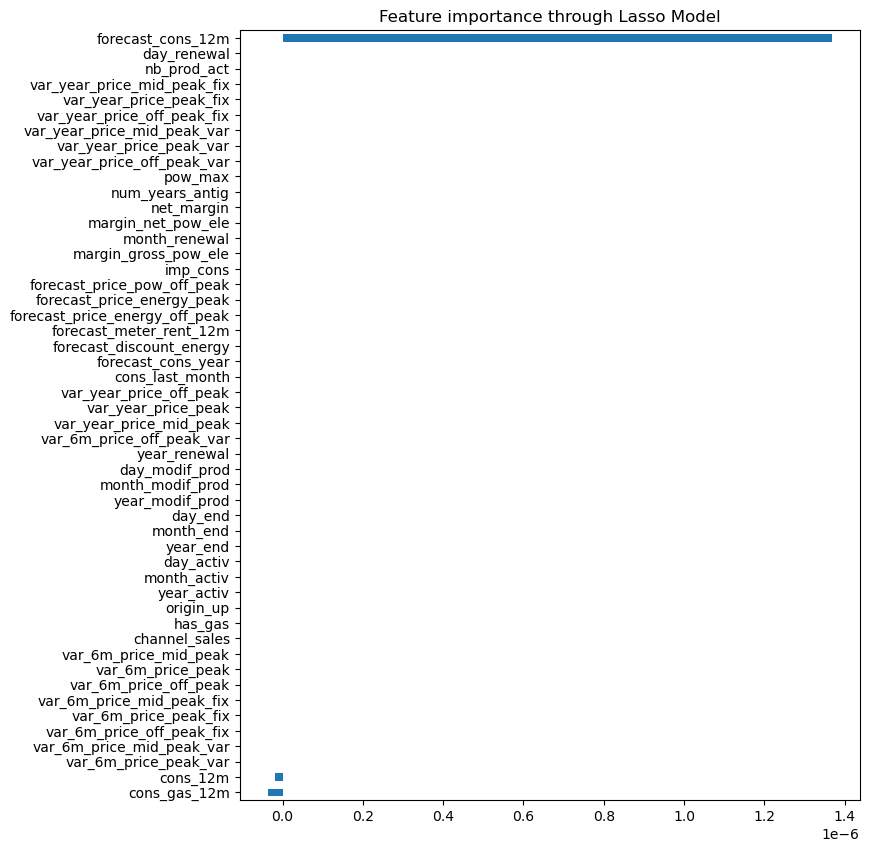

In [134]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance through Lasso Model")

## Feature Selection

In [ ]:
kept_df = df.drop(columns=["id"])